In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy import stats
from scipy.stats import norm
!pip install --quiet yfinance
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")


2. Escoja 5 acciones que hagan parte del índice Dow Jones (DJI). Con la información
histórica de estas acciones para un periodo de al menos 5 años con periodicidad mensual y
con cierre a Dic-2022, construya el portafolio óptimo tangente (máximo ratio de Sharpe).



a. Presentar el grafico de pesos y sus medidas de retorno esperado y volatilidad. Nota:
tomar solo posiciones largas en el portafolio.

In [ ]:
activos = ["MCD","BA","PG","VZ","PFE"] 
precios = yf.download(activos, start="2017-12-01",end="2022-12-31",interval="1Mo")['Adj Close']
retornos = np.log(precios/precios.shift()).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()

[*********************100%***********************]  5 of 5 completed


In [ ]:
n = len(mu)
x = cp.Variable(n)
objetivo = cp.Minimize(cp.quad_form(x, cov))
restricciones = [x @ mu == 1, x >= 0]
prob = cp.Problem(objetivo, restricciones)
prob.solve()
wpt = x.value/x.value.sum()
wpt

array([4.16988181e-20, 1.93648541e-01, 1.61573257e-01, 6.44778202e-01,
       4.23213775e-21])

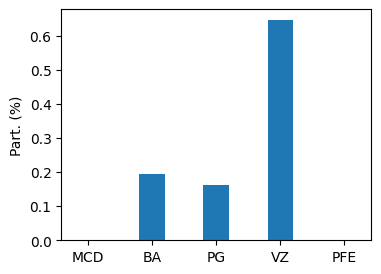

In [ ]:
plt.figure(figsize = (4, 3))
plt.bar(activos, x.value/x.value.sum(), width = 0.4)
plt.ylabel("Part. (%)")
plt.show();

In [ ]:
ret_port = retornos @ wpt
rpt = ret_port.mean()
sigmapt = ret_port.std()
rpt*12, sigmapt*np.sqrt(12)

(0.1219654940390333, 0.15578753787612487)

b. Calcular el VaR del portafolio para los niveles de confianza del 95% y 99%. Usar el
modelo estándar o paramétrico.

In [ ]:
activos = ["MCD","BA","PG","VZ","PFE"] 
precios = yf.download(activos, start="2017-12-01",end="2022-12-31",interval="1Mo")['Adj Close']
retornos = np.log(precios/precios.shift()).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()

[*********************100%***********************]  5 of 5 completed


In [ ]:
rp = retornos.mean()
sigmap = retornos.std()

alpha = 0.05
 
VaRp = rp - norm.ppf(1-alpha)*sigmap 
VaRp

BA    -0.238158
MCD   -0.081869
PFE   -0.110128
PG    -0.071981
VZ    -0.082451
dtype: float64

In [ ]:
rp2 = retornos.mean()
sigmap2 = retornos.std()

alpha2 = 0.01
 
VaRp2 = rp2 - norm.ppf(1-alpha2)*sigmap2 
VaRp2

BA    -0.334145
MCD   -0.119547
PFE   -0.159771
PG    -0.106200
VZ    -0.116149
dtype: float64

c. Calcular el VaR del portafolio para los niveles de confianza del 95% y 99%. Usar el
modelo de estimación histórica.

In [ ]:
var_hist = retornos.quantile(0.05)
var_hist

BA    -0.153703
MCD   -0.083980
PFE   -0.108040
PG    -0.087406
VZ    -0.094216
Name: 0.05, dtype: float64

In [ ]:
var_hist2 = retornos.quantile(0.01)
var_hist2

BA    -0.413972
MCD   -0.120607
PFE   -0.126801
PG    -0.090615
VZ    -0.103246
Name: 0.01, dtype: float64

d. Utilice el método de Monte Carlo para construir una muestra aleatoria de 10.000
portafolios. Con esta muestra aleatoria calcular el VaR de simulación del portafolio.

In [ ]:
port_rand = 10000
weights = np.zeros((port_rand, n))
for i in range(port_rand):
    w = np.random.random(n)
    w = w / np.sum(w)            
    weights[i,:] = w 

In [ ]:
t = len(retornos.iloc[:,1])
rand_returns = np.zeros((t,port_rand))
for i in range(port_rand):
  rand_returns[:,i] = retornos @ weights[i,:]

In [ ]:
h=0
omega_port = np.zeros(port_rand)
for i in range(port_rand):
  excesos = rand_returns[:,i]-h
  pos_ret = excesos[excesos>h].sum()
  neg_ret = excesos[excesos<h].sum()
  omega_port[i] = pos_ret / (-neg_ret )

In [ ]:
omega_portfolio = np.argmax(omega_port)
omega_weights = weights[omega_portfolio,:]
omega_weights 

3.

a)

In [ ]:
precios3 = yf.download("VZ", start="2021-12-01",end="2022-12-31",interval="1Mo")['Adj Close']
retornos3 = np.log(precios3/precios3.shift()).dropna()
mu3 = retornos3.mean()

[*********************100%***********************]  1 of 1 completed


In [ ]:
retornos3

Date
2022-01-01    0.024148
2022-02-01    0.020208
2022-03-01   -0.052206
2022-04-01   -0.095507
2022-05-01    0.114457
2022-06-01   -0.010584
2022-07-01   -0.094148
2022-08-01   -0.087125
2022-09-01   -0.096339
2022-10-01   -0.015928
2022-11-01    0.058893
2022-12-01    0.010717
Name: Adj Close, dtype: float64

In [ ]:
precios3

Date
2021-12-01    47.711239
2022-01-01    48.877392
2022-02-01    49.875168
2022-03-01    47.338200
2022-04-01    43.026276
2022-05-01    48.243828
2022-06-01    47.735897
2022-07-01    43.446720
2022-08-01    39.821632
2022-09-01    36.164253
2022-10-01    35.592785
2022-11-01    37.751900
2022-12-01    38.158672
Name: Adj Close, dtype: float64

In [ ]:
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    return S

In [ ]:
T= 1 # Un Año
mu = retornos3.mean()*12
sigma = retornos3.std()*np.sqrt(12)
S0 = 38
NS = 10000 #Número de trayectorias
M = 12 # Partición del año en periodos (días (252), semestres, meses)
St = PathsGBM(S0,mu,sigma,T,NS,M)

Text(0.5, 0, 'Tiempo')

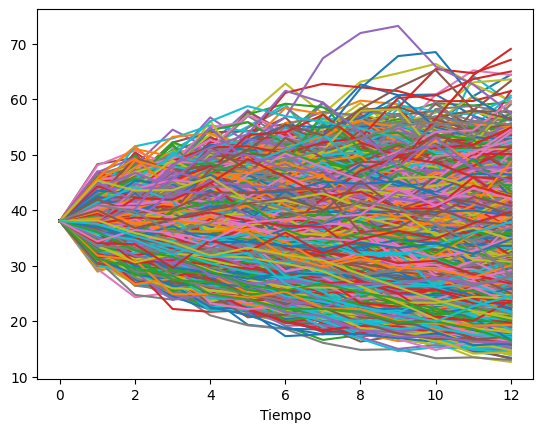

In [ ]:
plt.plot(np.transpose(St)) 
plt.xlabel("Tiempo")

b)

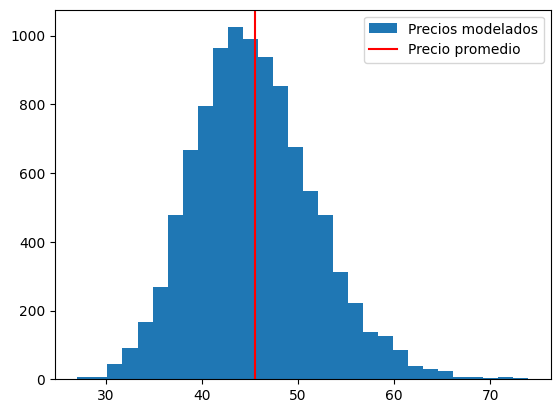

In [ ]:
plt.hist(St[:,-1], bins=30, label='Precios modelados')
plt.axvline(St[:,-1].mean(), color='r', label='Precio promedio')
plt.legend();

Del histograma se puede deducir que los precios se distrubuyen de forma normal

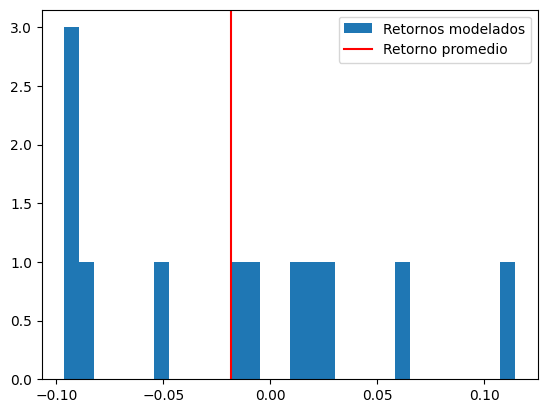

In [ ]:
plt.hist(retornos3, bins=30, label='Retornos modelados')
plt.axvline(retornos3.mean(), color='r', label='Retorno promedio')
plt.legend();

d)

In [ ]:
from scipy.stats import norm 
mu, std = norm.fit(precios)
probabilidad = norm.cdf(38, loc=mu, scale=std)
probabilidad

0.16790301581036166

La probabilidad de que el precio de la acción sea menor al valor de cierre de diciembre de 2022 es de 16.79%

4.

In [ ]:
t0 = 1
T = 5 # Año
steps = 252
k = 1
mu = 3
sigma = 0.3

t = np.linspace(t0,T,steps) # time axis
dt = np.mean(np.diff(t))
y = np.zeros(steps)

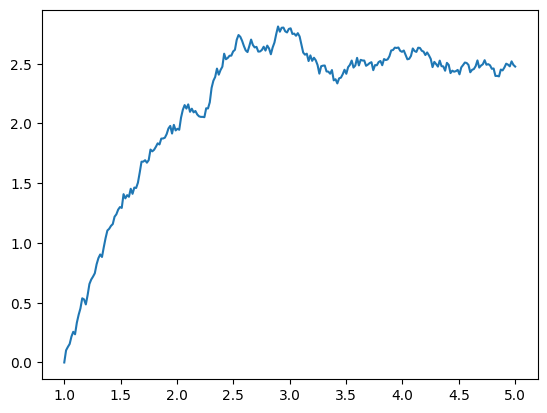

In [ ]:
y0 = np.random.normal(0,1) 
drift = lambda y,t: k*(mu-y) 
diffusion = lambda y,t: sigma 

noise = np.random.normal(0,1,steps)*np.sqrt(dt) 
# solve SDE
for i in range(1,steps):
 y[i] = y[i-1] + drift(y[i-1],i*dt)*dt + diffusion(y[i-1],i*dt)*noise[i]

plt.plot(t,y);